# Notes on evaluating proportion forecasts

## Set up

In a problem like variant proportion nowcasting, we are interested in a parameter $\mu_t = (\mu_{t1}, \ldots, \mu_{tK})$ where $K$ is the number of classes (in our example, the number of variants under consideration) and $\mu_{tk}$ is the proportion of the population that has variant $k$ at time $t$, with each $\mu_{tk} \geq 0$ and $\sum_k \mu_{tk} = 1$.

At time $t$, the available data are a vector of counts $c_{t} = (c_{t1}, \ldots, c_{tK})$ of cases in each variant class, with $\sum_k c_{tk} = n_t$ being the total number of samples observed on day $t$.  We can regard both the sample size $n_t$ and the counts $c_t$ as being realizations of the random variables $N_t$ and $C_t$.

## A proposed evaluation and elicitation method

We are considering the following scheme for forecast evaluation:

1. a forecaster submits a prediction that is intended to be a representation of the forecast distribution $\hat{F}_{\mu_t}$ for the population proportions $\mu_t$. For example, they might submit a collection of $m$ samples from this distribution.
2. the hub specifies a conditional distribution for the observed sample counts given $\mu_t$ and the sample size $n_t$, $F_{C_t \mid \mu_t, n_t}$.  For example, the hub might specify that $C_t \mid \mu_t, n_t \sim Multinomial(\mu_t, n_t)$.
3. Once finalized sample values are reported, we evaluate the conditional forecast distribution for the counts given $N_t = n_t$.  For expository purposes, if $\hat{F}_{\mu_t}$ and $F_{C \mid \mu}$ have densities $\hat{f}_{\mu_t}$ and $f_{C \mid \mu}$, this can be computed as $\hat{f}_{C_t \mid n_t}(c) = \int f_{C_t \mid \mu_t, n_t}(c) \hat{f}_{\mu_t}(\mu) \, d \mu$.  We can compute some proper score $S(\hat{f}_{C_t \mid n_t}, c_t)$ that measures the success of the forecast for the data $c_t$ that is derived from the submission $\hat{F}_{\mu_t}$.

The purpose of this is to avoid the requirement that teams contributing to the hub model the distribution of $N_t$, which is not epidemiologically interesting.

## Challenge: partial reporting

In a nowcasting exercise, it will often be the case that some partial data reports are available for some past date for which a prediction is requested. To simplify the discussion, first suppose that a team knows how many samples $n_t$ will eventually be reported, but at the time of the forecast $m_t$ samples have been collected (with $0 < m_t \leq n_t$). We'll briefly comment on a setting where the final count $n_t$ is unknown later.

Additionally, suppose that the population is large, that samples that are reported on different days are independent, and that sample counts do follow a multinomial distribution. Write $A_t$ for the samples that have been reported on the nowcast creation date (with $\sum_k a_{tk} = m_t$) and $B_t$ for the samples for date $t$ that will be reported, but have not yet been reported on the nowcast creation date (with $\sum_k b_{tk} = n_t - m_t$). We get to:
\begin{align*}
A_t \mid \mu_t, m_t &\sim Multnomial(\mu_t, m_t) \\
B_t \mid \mu_t, m_t, n_t &\sim Multnomial(\mu_t, n_t - m_t),
\end{align*}
with $A_t$ and $B_t$ being independent so that $C_t = A_t + B_t \sim Multinomial(\mu_t, n_t)$

In a setting where $A_t = a_t$ has been observed, what should a forecaster report? In other words, what quantity are we eliciting for a submission? I didn't do any formal derivations here, but my intuition is that we are not eliciting the mean parameter $\mu_t$, but rather some quantity in between $\mu_t$ and the sample proportions that have been reported at the time of nowcast creation, $a_t / m_t$, with the elicited value being closer to the reported proportions to date the larger $m_t / n_t$ is. This is because we will eventually be scoring data against the final reported counts $c_t$, and if $n_t - m_t$ is small only a small shift away from the sample proportions $a_t / m_t$ is possible.

### Illustration

Suppose that $n_t = 50$ and $\mu_t = (0.1, 0.3, 0.6)$ with $K = 3$ classes.  Additionally, suppose that $m_t = 40$, so a fairly complete report is available at the time of the nowcast.  We consider a setting where a forecaster is asked to submit a single point estimate $\hat{\mu}_t$, and we will evaluate it against the data using either the mean squared error (almost Brier score) or something like a log score based on the specified Multinomial distribution for the data. We will examine a range of possible submissions of the form
$$\hat{\mu}_t = \alpha \cdot a_t / m_t + (1 - \alpha) \cdot \mu_t$$
for interpolation factors $\alpha$ ranging from 0 to 1.  A value of $\alpha$ close to 1 means that the submission is close to the partially reported sample values, while a value of $\alpha$ close to 0 means that the submission is close to the population proportion $\mu_t$.

The following code blocks illustrate the ideas for one simulation replicate (with a sparse grid for alpha, made more dense below):


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multinomial
import matplotlib.pyplot as plt


In [2]:
rng = np.random.default_rng(seed=42)

m = 40
n = 50
mu = np.array([0.1, 0.3, 0.6])

a = rng.multinomial(n=m, pvals = mu)
b = rng.multinomial(n=n-m, pvals = mu)
c = a + b
print(f'a = {a}, b = {b}, c = {c}')

print(f'a/m = {a/m}')
print(f'c/n = {c/n}')

n_alpha = 10
alpha = np.linspace(0.01, 0.99, n_alpha).reshape(n_alpha, 1)
print(f'alpha = {alpha}')

mu_hat = alpha * a / m + (1 - alpha) * mu
print(f'mu_hat = {mu_hat}')

log_score = multinomial(n=n, p=mu_hat).logpmf(c)
mse = np.mean((mu_hat - c/n)**2, axis=1)

scores = pd.DataFrame({
  'alpha': alpha.squeeze(),
  'log_score': log_score,
  'mse': mse
})
scores

a = [ 5 11 24], b = [2 3 5], c = [ 7 14 29]
a/m = [0.125 0.275 0.6  ]
c/n = [0.14 0.28 0.58]
alpha = [[0.01      ]
 [0.11888889]
 [0.22777778]
 [0.33666667]
 [0.44555556]
 [0.55444444]
 [0.66333333]
 [0.77222222]
 [0.88111111]
 [0.99      ]]
mu_hat = [[0.10025    0.29975    0.6       ]
 [0.10297222 0.29702778 0.6       ]
 [0.10569444 0.29430556 0.6       ]
 [0.10841667 0.29158333 0.6       ]
 [0.11113889 0.28886111 0.6       ]
 [0.11386111 0.28613889 0.6       ]
 [0.11658333 0.28341667 0.6       ]
 [0.11930556 0.28069444 0.6       ]
 [0.12202778 0.27797222 0.6       ]
 [0.12475    0.27525    0.6       ]]


,alpha,log_score,mse
0,0.010000,-4.277506,0.000790
1,0.118889,-4.217684,0.000687
2,0.227778,-4.163933,0.000594
3,0.336667,-4.116024,0.000511
4,0.445556,-4.073750,0.000437
5,0.554444,-4.036920,0.000374
6,0.663333,-4.005360,0.000320
7,0.772222,-3.978910,0.000276
8,0.881111,-3.957421,0.000242
9,0.990000,-3.940760,0.000218


Now we repeat the above for 10000 replicates and summarize the results:

In [3]:
def one_sim_replicate(mu = np.array([0.1, 0.3, 0.6]), m = 40, n = 50, n_alpha = 99):
  a = rng.multinomial(n=m, pvals = mu)
  b = rng.multinomial(n=n-m, pvals = mu)
  c = a + b

  alpha = np.linspace(0.01, 0.99, n_alpha).reshape(n_alpha, 1)

  mu_hat = alpha * a / m + (1 - alpha) * mu
  mu_hat[mu_hat < 0] = 0
  mu_hat = mu_hat / np.sum(mu_hat, axis = 1, keepdims=True)

  log_score = multinomial(n=n, p=mu_hat).logpmf(c)
  mse = np.mean((mu_hat - c/n)**2, axis=1)

  scores = pd.DataFrame({
    'alpha': alpha.squeeze(),
    'log_score': log_score,
    'mse': mse
  })
  
  return scores

all_scores = pd.concat([
  one_sim_replicate().assign(replicate_index = i) \
    for i in range(10000)
])

all_scores

,alpha,log_score,mse,replicate_index
0,0.01,-6.498582,0.014892,0
1,0.02,-6.433797,0.014586,0
2,0.03,-6.369979,0.014285,0
3,0.04,-6.307122,0.013986,0
4,0.05,-6.245217,0.013691,0
...,...,...,...,...
94,0.95,-3.907413,0.002289,9999
95,0.96,-3.892185,0.002219,9999
96,0.97,-3.877165,0.002150,9999
97,0.98,-3.862354,0.002082,9999


In [4]:
mean_scores = all_scores.drop(columns='replicate_index') \
  .groupby('alpha', as_index = False) \
  .mean()

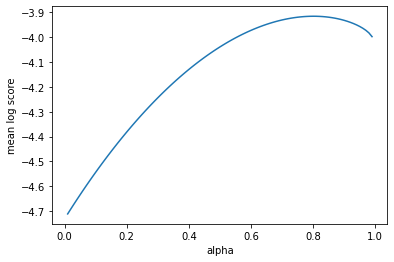

In [5]:
plt.plot(mean_scores['alpha'], mean_scores['log_score'])
plt.xlabel('alpha')
plt.ylabel('mean log score')
plt.show()

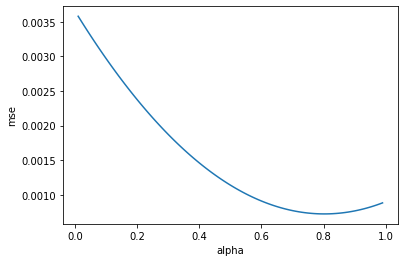

In [6]:
plt.plot(mean_scores['alpha'], mean_scores['mse'])
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

Here we replicate the above, with $m = 20$ samples (40% of the final sample size) reported as of the time the prediction is submitted:

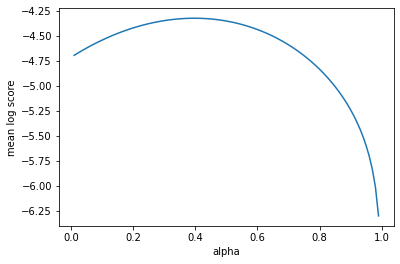

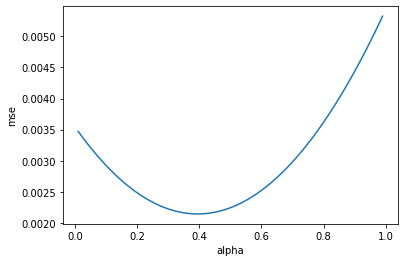

In [7]:
all_scores_m20 = pd.concat([
  one_sim_replicate(m = 20).assign(replicate_index = i) \
    for i in range(10000)
])

mean_scores_m20 = all_scores_m20.drop(columns='replicate_index') \
  .groupby('alpha', as_index = False) \
  .mean()

plt.plot(mean_scores_m20['alpha'], mean_scores_m20['log_score'])
plt.xlabel('alpha')
plt.ylabel('mean log score')
plt.show()

plt.plot(mean_scores_m20['alpha'], mean_scores_m20['mse'])
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()


For both scores (log score and MSE), in expectation the forecaster is rewarded for submitting not the population mean $\mu_t$, but a version of $\mu_t$ that has been shrunk toward the sample proportions available in any partially reported data.  The amount by which the submitted value should shrink toward the sample proportions depends on the proportion of the final sample size that has been reported as of the time the prediction is generated.

However, these behaviors are what we tried to avoid with our proposed evaluation scheme above!

 - In the presence of partially reported data, we are not eliciting predictions of the population mean $\mu_t$
 - In the presence of partially reported data, modelers are encouraged to model the final sample size $N_t$ so that they can determine the right shrinkage factor to use.

## Where next?

I think our idea might have worked for a forecasting exercise -- but in the hub we're setting up, we're interested in nowcasting, including nowcasting for past dates where some partial data reports are available. My current understanding is that the ideas we've outlined for forecast submission and evaluation don't get us where we want to go in that kind of setting. I think the heart of the problem is that we will be comparing forecasts to the observed data, and when some (fairly complete) partial data reports are available, a good nowcast will make a prediction that matches those partial data well, potentially moving the prediction away from the population mean. This is particularly an issue when final reported sample counts are small, in which case there may be a lot of noise in the final reported sample proportions and we don't want to see predictions that follow that noise closely.

I'd like to suggest that we consider returning to ideas where we explicitly target and score predictions of observed data, potentially after smoothing the data to reduce some of the issues with noise in low-count daily observations.  One smoother that's often been used historically in other forecasting exercises is a trailing 7-day sum, i.e., weekly counts.  In our case, the natural translation of that idea would be weekly proportions, i.e., sample proportions based on the total set of samples collected in the 7 days ending on a target date.  If we wanted to see how things are changing on a daily basis, we could consider predictions of the proportions in a rolling 7 day window ending on each day throughout a period of interest.  This would tend to lag the proportions on the current date if based on a trailing 7 day window, so we could also consider centering the rolling window on the target date (target date - 3, target date - 2, ..., target date + 3).  We might also want to consider possible impacts of different sample sizes on different dates, and whether or not we think it's appropriate for dates within a 7-day window that have more samples to dominate the computation of the target value.
